# Generate Approximate Hessians
Use the random displacement data to get the full Hessian matrix. We assume that many parameters of the Hessian matrix are zero, and therefore that we can fit the Hessian matrix with a reduced number of points using [sparse linear regression](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jitterbug.model.linear import LinearHessianModel
from sklearn.linear_model import LinearRegression, LassoCV
from ase.vibrations import VibrationsData
from ase.db import connect
from pathlib import Path
from tqdm import tqdm
import numpy as np

Configuration

In [2]:
molecule_name = 'caffeine'
method = 'hf'
basis = 'def2-svpd'
step_size: float = 0.005 # Perturbation amount, used as maximum L2 norm

Derived

In [3]:
run_name = f'{molecule_name}_{method}_{basis}'
out_dir = Path('data') / 'approx'
db_path = out_dir / f'{run_name}-random-d={step_size:.2e}.db'

## Read in the Data
Get all computations for the desired calculation and the exact solution

In [4]:
with connect(db_path) as db:
    data = [a.toatoms() for a in db.select('')]
print(f'Loaded {len(data)} structures')

Loaded 252 structures


Read in the exact Hessian

In [5]:
with open(f'data/exact/{run_name}-ase.json') as fp:
    exact_vibs = VibrationsData.read(fp)

In [6]:
exact_hess = exact_vibs.get_hessian_2d()
exact_zpe = exact_vibs.get_zero_point_energy()

## Fit a Hessian with All Data
Fit a model which explains the energy data by fitting a Hessian matrix using compressed sensing (i.e., Lasso).

In [7]:
model = LinearHessianModel(reference=data[0], regressor=LassoCV)
hess_model = model.train(data)

Get the mean Hessian

In [8]:
approx_hessian = model.mean_hessian(hess_model)

Compare to exact answer

In [9]:
exact_hess[:3, :3]

array([[1.96495560e+01, 2.28518485e+01, 1.08009177e-03],
       [2.28518485e+01, 8.36964299e+01, 3.94902961e-03],
       [1.08009177e-03, 3.94902961e-03, 4.15881408e+00]])

In [10]:
approx_hessian[:3, :3]

array([[ 22.92078111,   0.        ,  -0.        ],
       [  0.        , 104.76017451,  -0.        ],
       [ -0.        ,  -0.        ,  17.33479829]])

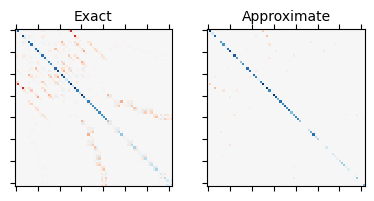

In [11]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Exact', 'Approximate'], [exact_hess, approx_hessian]):
    ax.matshow(h, vmin=-100, vmax=100, cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the zero point energy

In [12]:
approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)

In [13]:
approx_vibs.get_zero_point_energy()

5.451357701087528

In [14]:
exact_zpe

5.5067174465850215

The two differ, but I'm not sure how important the difference is.

## Plot as a Function of Data
See what happens as we add more data to the training

In [15]:
steps = np.linspace(5, len(data), 16, dtype=int)
print(f'Plotting at {len(steps)} steps: {", ".join(map(str, steps[:5]))}, ...')

Plotting at 16 steps: 5, 21, 37, 54, 70, ...


In [16]:
zpes = []
for count in tqdm(steps):
    model = LinearHessianModel(reference=data[0], regressor=LassoCV)
    hess_model = model.train(data[:count])
    
    approx_hessian = model.mean_hessian(hess_model)
    approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)
    zpes.append(approx_vibs.get_zero_point_energy())

  6%|███████████████▍                                                                                                                                                                                                                                      | 1/16 [00:00<00:06,  2.21it/s]/home/lward/miniconda3/envs/jitterbug/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-09, tolerance: 5.772e-10
  model = cd_fast.enet_coordinate_descent(
 25%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                                        | 4/16 [00:02<00:09,  1.32it/s]/home/lward/miniconda3/envs/jitterbug/lib/python3.10/site-pa

Plot it

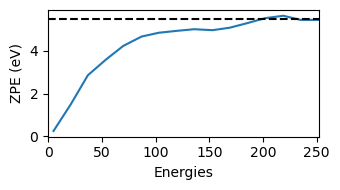

In [17]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ax.plot(steps, zpes)

ax.set_xlim([0, steps.max()])
ax.plot(ax.get_xlim(), [exact_zpe]*2, 'k--')

ax.set_xlabel('Energies')
ax.set_ylabel('ZPE (eV)')

fig.tight_layout()

We consistently underestimate the ZPE. Is it because we have too few oscillators?